In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from shapely.geometry import LineString, Point, Polygon
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#import fiona
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from osgeo import gdal, ogr, osr

import os 

idx = pd.IndexSlice

In [2]:
# Toggle between users

upath = r'N:\DIGITAL\Project data\FAIRiCUBE\uc_building_stock'

#### Load building semantic data & reproject the coordinate to epsg:25833

In [3]:
oslo = gpd.read_file(os.path.join(upath,r'osl_test\oslo_kommune\bygg_140623.shp')).to_crs('epsg:25833')

#### Extraction of building geometries from openstreetmap & reproject the coordinate to epsg:25833

In [4]:
%%time
# Setting a boundary box for a small neighborhood in Oslo, Norway
south, east, north, west = [59.91603,10.75669,59.91883,10.74709]

# Extracting data associated with building
buildings = ox.geometries_from_bbox(north, south, east, west, tags = {'building': True})

# attributes of interest associated with buildings
bcols = ['geometry', 'building']
bdata = buildings[bcols]

# extracting only polygon geometries for buildigns
bdata = bdata[bdata['geometry'].geom_type == 'Polygon'].to_crs('epsg:25833')

CPU times: total: 172 ms
Wall time: 187 ms


<timed exec>:5: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.


#### Overlay semantic data to OSM data

<Axes: >

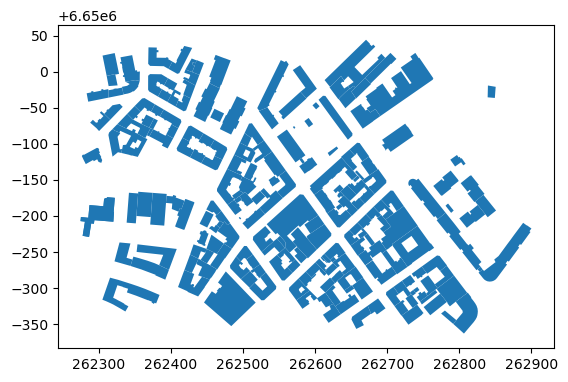

In [5]:
oslo_bygg = bdata.sjoin(oslo, how='left')
oslo_bygg.plot()

#### Loading building height data (DEM) data from Kartverket (https://hoydedata.no/LaserInnsyn2/) and calculating Canopy Height Model (CHM)

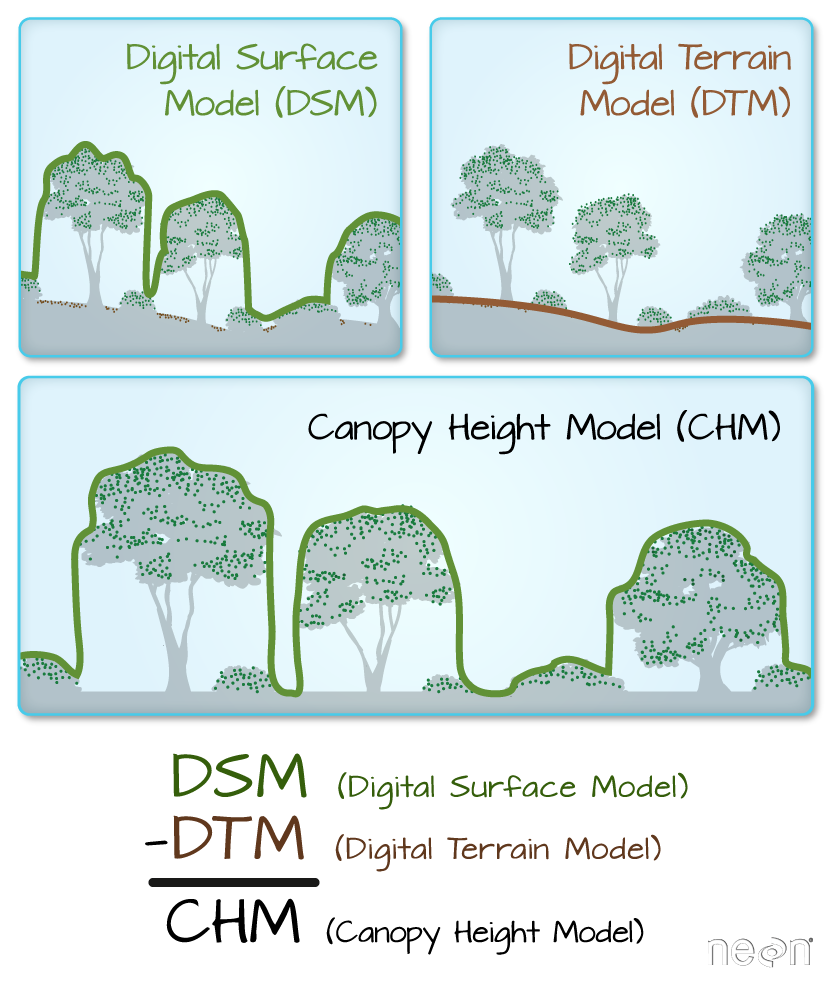

In [6]:
%%time
# Here, the DEM data are extracted manually from the web service. However, in the future, it might ...
# worthwhile finding an API solution to avoid manual data extraction routines.

# Reading and concatination of DTM and DSM files

# get list of DTM files in the following directory
fd_dtm = os.path.join(upath, r'osl_test\kartverket\dtm')
dtmfiles = []

for fn in os.listdir(fd_dtm):
    if os.path.isfile(os.path.join(fd_dtm, fn)) and fn.split('.')[-1] == 'tif':
        dtmfiles.append(os.path.join(fd_dtm,fn))


# get list of DSM files in the following directory
fd_dsm = os.path.join(upath, r'osl_test\kartverket\dsm')
dsmfiles = []

for fn in os.listdir(fd_dsm):
    if os.path.isfile(os.path.join(fd_dsm, fn)) and fn.split('.')[-1] == 'tif':
        dsmfiles.append(os.path.join(fd_dsm,fn))
        


CPU times: total: 31.2 ms
Wall time: 133 ms


##### merging geotiff rasterfiles to create mosaics 

In [7]:
# Creating mosaic for DTM data
dtm_raster_to_mosaic = []
for p in dtmfiles:
    dtm_raster_to_mosaic.append(rasterio.open(p)) 

mosaic, output = merge(dtm_raster_to_mosaic)

out_meta = rasterio.open(p).meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": output,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "}
                 )

with rasterio.open(os.path.join(upath, 
                                r'osl_test\kartverket\mosaic\dtm_mosaic.tif'),
                  "w", **out_meta) as dest:
    dest.write(mosaic)
    
# Creating mosaic for DSM data
dsm_raster_to_mosaic = []
for p in dsmfiles:
    dsm_raster_to_mosaic.append(rasterio.open(p)) 

mosaic, output = merge(dsm_raster_to_mosaic)

out_meta = rasterio.open(p).meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": output,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "}
#                  "crs": 'EPSG:25833'}
                 )

with rasterio.open(os.path.join(upath, 
                                r'osl_test\kartverket\mosaic\dsm_mosaic.tif'),
                  "w", **out_meta) as dest:
    dest.write(mosaic)

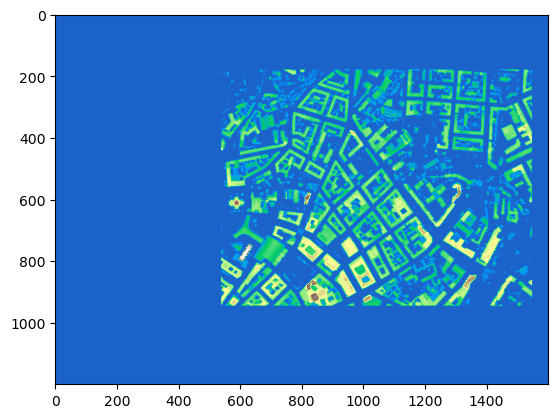

In [8]:
# loading the mosaiced DTM and DSM data and subtracting their height differences
DTM = rasterio.open(os.path.join(upath, r'osl_test\kartverket\mosaic\dtm_mosaic.tif'))
DSM = rasterio.open(os.path.join(upath, r'osl_test\kartverket\mosaic\dsm_mosaic.tif'))

# calculating Canopy Height Model (CHM)
chm = DSM.read(1, masked=True) - DTM.read(1, masked=True)

show(chm, cmap='terrain')

# writing the CHM tif file and appending DTM metadata to it 
with rasterio.open(os.path.join(upath, r'osl_test\kartverket\mosaic\chm_mosaic.tif'), 
                   'w', **DTM.profile) as dest:
    dest.write(chm,1)

##### Converting CHM raster to a shape file 

In [9]:
%%time
CHM = gdal.Open(os.path.join(upath, r'osl_test\kartverket\mosaic\chm_mosaic.tif'))
band = CHM.GetRasterBand(1)

# appending the same projection from CHM data to the shape file
proj = CHM.GetProjection()
shp_proj = osr.SpatialReference(proj)

output_file = os.path.join(upath, r'osl_test\kartverket\mosaic\chm.shp')
call_drive = ogr.GetDriverByName('ESRI Shapefile')
create_shp = call_drive.CreateDataSource(output_file)
shp_layer = create_shp.CreateLayer('layername', srs = shp_proj)
new_field = ogr.FieldDefn(str('ID'),ogr.OFTInteger)
shp_layer.CreateField(new_field)

gdal.Polygonize(band, None, shp_layer, 0, [], callback= None)
create_shp.Destroy()
CHM = None

CPU times: total: 3.36 s
Wall time: 4.59 s


##### testing whether the conversion is correctly done or not

In [10]:
CHM_shp = gpd.read_file(os.path.join(upath, r'osl_test\kartverket\mosaic\chm.shp'))

In [14]:
CHM_shp.crs

<Projected CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_Unk ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: D_Unknown_based_on_GRS80_ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
oslo_bygg_height = dem.dissolve(by=['osmid', 'building'], 
                                aggfunc = {'z_meter': 'mean'
                                          })

In [ ]:
osl_bygg = oslo_bygg.reset_index()
osl_bygg["NEIGHBORS"] = None
osl_bygg["WALL_LENGTH"] = None
osl_bygg["WALL_HEIGHT"] = None

#### Finding neighboring building & calculating amount of shared walls

In [ ]:
# creating an empty dataframe to contain information on shared wall area
#data_overlaps = gpd.GeoDataFrame()

# check if intersection occured with neighboring buildings
for index, row in osl_bygg.iterrows():
    
    # get 'not disjoint' buildings
    neighbors = osl_bygg[~osl_bygg.geometry.disjoint(row.geometry)].osmid.tolist()

    # remove own building ID of the building ID from the list
    neighbors = [byggid for byggid in neighbors if row.osmid != byggid ]
    
    # add building ID of neighbors as NEIGHBORS value
    osl_bygg.at[index, "NEIGHBORS"] = neighbors
    
    # calculating shared walls with neighboring buildings
    wall_length = [row.geometry.intersection(osl_bygg[osl_bygg['osmid'] == i].geometry.iloc[0]) for i in neighbors]
    
   # add lengths of shared walls of neighbors as WALL_LENGTH values
    osl_bygg.at[index, "WALL_LENGTH"] = wall_length    


# The height of shared wall between the buildings need to be calculated based on ...
# the height calculated results. At the moment, such values do not exist for open-access ...
# data; however, it is expected to estimate building height from DEM values. 
#         wall_height =
    